In [2]:
#importamos las librerias necesarias para el proceso

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 


####  Cargamos todos los datos demograficos de los clientes


In [4]:
df_demo = pd.read_csv('data/raw/df_final_demo.txt')
df_demo.head(5)

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth
0,836976,6.0,73.0,60.5,U,2.0,45105.30,6.0,9.0
1,2304905,7.0,94.0,58.0,U,2.0,110860.30,6.0,9.0
2,1439522,5.0,64.0,32.0,U,2.0,52467.79,6.0,9.0
3,1562045,16.0,198.0,49.0,M,2.0,67454.65,3.0,6.0
4,5126305,12.0,145.0,33.0,F,2.0,103671.75,0.0,3.0


In [6]:
# Buscamos cuantos nulos tenemos. 
null_percentage = df_demo.isnull().mean().sort_values(ascending=False) * 100

# Formateamos los valores con dos decimales y el símbolo %
null_percentage_formatted = null_percentage.apply(lambda x: f"{x:.2f}%")

print("Porcentaje de valores nulos por columna:")
print(null_percentage_formatted)

Porcentaje de valores nulos por columna:
clnt_age            0.02%
num_accts           0.02%
clnt_tenure_yr      0.02%
clnt_tenure_mnth    0.02%
gendr               0.02%
calls_6_mnth        0.02%
bal                 0.02%
logons_6_mnth       0.02%
client_id           0.00%
dtype: object


In [ ]:
def limpiar_demograficos(df):
    # Renombra columnas para mayor claridad
    df = df.rename(columns={
        'clnt_tenure_yr': 'client_tenure_years',
        'clnt_tenure_mnth': 'client_tenure_months',
        'clnt_age': 'age',
        'gendr': 'gender',
        'num_accts': 'number_of_accounts',
        'bal': 'balance',
    })

    # Elimina filas con valores nulos (menos del 0.02% del total)
    df = df.dropna()

    # Normaliza género: reemplaza 'X' por 'U' (Unknown)
    df["gender"] = df["gender"].replace({"X": "U"})

    # Convierte la edad a entero truncado (elimina .5)
    df["age"] = df["age"].astype(int)

    return df


df_demo_clean = limpiar_demograficos(df_demo)


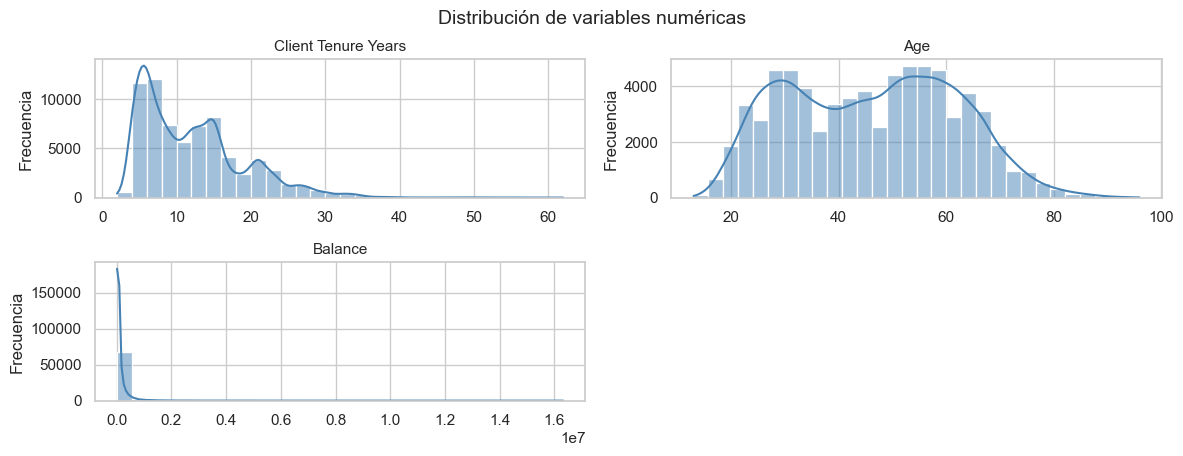

In [23]:
# Columnas a graficar (asegúrate que existen en el df)
cols_to_plot = ['client_tenure_years', 'age', 'balance']
cols_to_plot = [col for col in cols_to_plot if col in df_demo_clean.columns]

# Configura el estilo visual
sns.set(style="whitegrid")

# Crear figura general
plt.figure(figsize=(12, 6))

# Iterar y graficar cada histograma
for idx, col in enumerate(cols_to_plot, 1):
    plt.subplot(3, 2, idx)
    sns.histplot(df_demo_clean[col], bins=30, kde=True, color='steelblue')
    plt.title(col.replace('_', ' ').title(), fontsize=11)
    plt.xlabel('')
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.suptitle('Distribución de variables numéricas', fontsize=14, y=1.02)
plt.show()

In [25]:
# Borramos aquellos clientes con permanencias superiores a sus edades 
inconsistentes = (df_demo_clean['client_tenure_years'] > df_demo_clean['age']).sum()
total = len(df_demo_clean)

proporcion = (inconsistentes / total) * 100

print(f"Clientes con permanencia > edad: {inconsistentes} de {total} ({proporcion:.4f}%)")

Clientes con permanencia > edad: 574 de 70594 (0.8131%)


In [27]:
# Borramos los datos que presentan outlier (IQR) 
def filtrar_outliers_iqr(df, columnas):

    df_filtrado = df.copy()
    for col in columnas:
        if col in df.columns:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            df_filtrado = df_filtrado[(df_filtrado[col] >= lower) & (df_filtrado[col] <= upper)]
    return df_filtrado


df_demo_iqr_filter = filtrar_outliers_iqr(df_demo_clean, cols_to_plot)

In [ ]:
# Segmentamos los clientes


#### Cargamos los datos del experimento     

In [13]:
df_experiment = pd.read_csv('data/raw/df_final_experiment_clients.txt')
df_experiment.head(10)

,client_id,Variation
0,9988021,Test
1,8320017,Test
2,4033851,Control
3,1982004,Test
4,9294070,Control
5,9466803,Test
6,3170143,Test
7,6651403,Control
8,5887227,Test
9,2105948,Control


In [15]:
df_experiment.isnull().sum()

client_id        0
Variation    20109
dtype: int64

In [16]:
# Buscamos cuantos nulos tenemos. 
null_percentage = df_experiment.isnull().mean().sort_values(ascending=False) * 100

# Formateamos los valores con dos decimales y el símbolo %
null_percentage_formatted = null_percentage.apply(lambda x: f"{x:.2f}%")

print("Porcentaje de valores nulos por columna:")
print(null_percentage_formatted)

Porcentaje de valores nulos por columna:
Variation    28.48%
client_id     0.00%
dtype: object


In [ ]:
df_clients = df_experiment.dropna(subset=["Variation"])
df_clients.to_csv("data/cleaned/df_final_experiment_clients_cleaned.csv", index=False)



#### Hacemos el merge de los dos archivos con los datos del funnel channel

In [21]:
df_webdata1 = pd.read_csv('data/raw/df_final_web_data_pt_1.txt', sep=',')
df_webdata2 = pd.read_csv('data/raw/df_final_web_data_pt_2.txt', sep=',')

In [29]:
def merge_dataframes(df1, df2, key='client_id'):
    
    merged_df = pd.merge(df1, df2, how='inner', on=key)

    # Eliminar columnas duplicadas que terminan en '_y'
    cols_to_drop = [col for col in merged_df.columns if col.endswith('_y')]
    merged_df.drop(columns=cols_to_drop, inplace=True)

    # Renombrar columnas que terminan en '_x' eliminando el sufijo
    merged_df.rename(columns={
        col: col.replace('_x', '') for col in merged_df.columns if col.endswith('_x')
    }, inplace=True)
    
    # Eliminar duplicados y ordenar por client_id y date_time
    merged_df = merged_df.drop_duplicates().sort_values(['client_id', 'date_time'])

    return merged_df

# Llamamos a la funcion para hacer el merge de los datos 
df_final_webdata = merge_dataframes(df_webdata1, df_webdata2)

# se guarda en la carpeta files para usarlo en el futuro 
df_final_webdata.to_csv('data/cleaned/df_final_web_data.csv', index=False)

#Cargamos el dataframe final para comprobar que se ha guardado correctamente. 
df_final_webdata = pd.read_csv('data/cleaned/df_final_web_data.csv',sep=',')
df_final_webdata.head(10)

,client_id,visitor_id,visit_id,process_step,date_time
0,1643,910842861_51062379179,379946188_1773022140_107963,start,2017-04-15 15:06:00
1,1643,910842861_51062379179,633860590_96880450633_976109,start,2017-04-24 06:36:07
2,1643,910842861_51062379179,633860590_96880450633_976109,step_1,2017-04-24 06:36:32
3,1643,910842861_51062379179,633860590_96880450633_976109,start,2017-04-24 06:37:17
4,1643,910842861_51062379179,633860590_96880450633_976109,start,2017-04-24 06:38:20
5,1677,361240963_15830034505,494607202_74539107264_966618,start,2017-03-31 10:59:27
6,1677,361240963_15830034505,494607202_74539107264_966618,step_1,2017-03-31 10:59:41
7,1677,361240963_15830034505,494607202_74539107264_966618,step_2,2017-03-31 11:00:40
8,1677,361240963_15830034505,494607202_74539107264_966618,start,2017-03-31 11:01:50
9,1680,262688118_24224945474,807102410_81976926205_767113,start,2017-03-15 09:57:21
